## Power Trace CDFs and Representative Plots

In [1]:
import argparse
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import seaborn as sns

from model.core.dataset import PowerTraceDataset
from model.core.utils import load_classifier
from model.predictors.smooth_sampler import SmoothingSampler

In [2]:
def compute_autocorrelation_metrics(real_trace, synthetic_trace, max_lags=50):
    """
    Compare temporal autocorrelation between real and synthetic traces
    """
    real_acf = acf(real_trace, nlags=max_lags, fft=True)
    synthetic_acf = acf(synthetic_trace, nlags=max_lags, fft=True)
    acf_correlation, _ = pearsonr(real_acf, synthetic_acf)
    acf_mae = np.mean(np.abs(real_acf - synthetic_acf))

    return {
        "real_acf": real_acf,
        "synthetic_acf": synthetic_acf,
        "acf_correlation": acf_correlation,
        "acf_mae": acf_mae,
    }


In [ ]:
# data_file = "./data/benchmark_gpt-oss-120b_a100.npz"
# model = "gpt-oss-120b"
# hardware_accelerator = "a100"
# weights_path = "./results/training/gpt-oss-120b_h100_tp4"
# device="cpu"
# hw="a100"

data_file = "./data/benchmark_llama-3-70b_a100.npz"
model = "llama-3-70b"
hardware_accelerator = "a100"
weights_path = "./results/training/llama-3-70b_h100_tp4"
device="cpu"
hw="a100"

In [15]:

dataset = PowerTraceDataset(data_file)
# tp = tp
# Define a consistent color key mapping for TP values
# Using matplotlib's default color cycle for consistency
tp_values = [4]
tp_color_key = {
    1: "#1f77b4",  # blue
    2: "#ff7f0e",  # orange
    4: "#2ca02c",  # green
    8: "#d62728",  # red
}

# Store all CDF data for plotting
cdf_data = []

print(dataset.traces[0]["x"].shape[1])

for tp in tp_values:
    print(f"\nProcessing TP={tp}")
    classifier = load_classifier(
        f"{weights_path}/model_tp{tp}_H64_biGRU.pt",
        device=device,
        Dx=dataset.traces[0]["x"].shape[1],
        K=6,
    )
    smoother = SmoothingSampler(dataset)
    tp_indices = [i for i, tp_i in enumerate(dataset.tp_all) if tp_i == tp]

    all_original_power = []
    all_sampled_power = []
    sampled_power_arrs = {}
    import scipy.stats as stats

    min_power = float("inf")
    max_power = float("-inf")
    for idx in tp_indices:
        trace_power = dataset.traces[idx]["y"].flatten()
        min_power = min(min_power, np.min(trace_power))
        max_power = max(max_power, np.max(trace_power))

    plt.clf()
    plt.plot(dataset.traces[tp_indices[0]]["z"].flatten(), color=tp_color_key[tp])
    plt.xlim(0, 50)
    plt.title("State Sequence for First Trace")
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.savefig(f"state_sequence_trace_{tp}.pdf")
    plt.close()
    plt.plot(dataset.traces[tp_indices[0]]["y"].flatten(), color=tp_color_key[tp])
    plt.xlim(0, 50)
    plt.title("Power Trace for First Trace")
    plt.xlabel("Time Step")
    plt.ylabel("Power (W)")
    plt.savefig(f"power_trace_{tp}.pdf")
    plt.close()

    for idx in tp_indices:
        time, power, states = smoother.sample_power(
            classifier,
            dataset.mu[tp],
            dataset.sigma[tp],
            dataset.traces[idx]["x"],
            dt=0.25,
            smoothing_window=5,
        )
        power = np.clip(power, min_power, max_power)
        original_power = dataset.traces[idx]["y"].flatten()
        sampled_power = power.flatten()
        sampled_power_arrs[idx] = (time, sampled_power)
        all_original_power.append(original_power)
        all_sampled_power.append(sampled_power)

    all_original_power = np.concatenate(all_original_power)
    all_sampled_power = np.concatenate(all_sampled_power)
    overall_ks_stat, overall_p_value = stats.ks_2samp(
        all_original_power, all_sampled_power
    )
    print(f"Overall - KS Statistic: {overall_ks_stat}, p-value: {overall_p_value}")
    sorted_original_power = np.sort(all_original_power)
    sorted_sampled_power = np.sort(all_sampled_power)

    cdf_original = np.arange(1, len(sorted_original_power) + 1) / len(
        sorted_original_power
    )
    cdf_sampled = np.arange(1, len(sorted_sampled_power) + 1) / len(
        sorted_sampled_power
    )

    # Add data to cdf_data list
    cdf_data.extend(
        [
            {"Power": p, "CDF": c, "Type": "Original", "TP": tp}
            for p, c in zip(sorted_original_power, cdf_original)
        ]
    )
    cdf_data.extend(
        [
            {"Power": p, "CDF": c, "Type": "Sampled", "TP": tp}
            for p, c in zip(sorted_sampled_power, cdf_sampled)
        ]
    )

    print(f"TP={tp} indices:", dataset.tp_all)

    total_energy_original = np.trapz(all_original_power, dx=0.25)
    total_energy_sampled = np.trapz(all_sampled_power, dx=0.25)
    print(f"Total energy consumed (original): {total_energy_original:.2f} J")
    print(f"Total energy consumed (sampled): {total_energy_sampled:.2f} J")
    print(
        f"Energy difference: {total_energy_sampled - total_energy_original:.2f} J"
    )

    # Compute autocorrelation metrics
    print("Computing autocorrelation metrics...")
    autocorr_metrics = compute_autocorrelation_metrics(
        all_original_power, all_sampled_power
    )
    print("Autocorrelation metrics:")
    print(f"ACF Correlation: {autocorr_metrics['acf_correlation']:.4f}")
    print(f"ACF MAE: {autocorr_metrics['acf_mae']:.4f}")

    # Compute earth mover's distance
    from scipy.stats import wasserstein_distance

    emd = wasserstein_distance(sorted_original_power, sorted_sampled_power)
    print(f"Earth Mover's Distance: {emd:.4f}")

    # Calculate p99 error
    p99_original = np.percentile(all_original_power, 99)
    p99_sampled = np.percentile(all_sampled_power, 99)
    p99_error = np.abs(p99_original - p99_sampled) / p99_original * 100
    print(f"P99 Error: {p99_error:.2f}%")

    # Calculate p95 error
    p95_original = np.percentile(all_original_power, 95)
    p95_sampled = np.percentile(all_sampled_power, 95)
    p95_error = np.abs(p95_original - p95_sampled) / p95_original * 100
    print(f"P95 Error: {p95_error:.2f}%")

    # Compute NRMSE
    nrmse = np.sqrt(np.mean((all_original_power - all_sampled_power) ** 2)) / (
        np.max(all_original_power) - np.min(all_original_power)
    )
    print(f"NRMSE: {nrmse:.4f}")

6

Processing TP=4
Loading classifier from ./results/training/gpt-oss-120b_h100_tp4/model_tp4_H64_biGRU.pt on device: cpu


/Users/grantwilkins/powertrace-sim/model/core/utils.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(path, map_location=device))


Overall - KS Statistic: 0.16497569224265485, p-value: 0.0
TP=4 indices: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Total energy consumed (original): 10151760.00 J
Total energy consumed (sampled): 10692964.80 J
Energy difference: 541204.80 J
Computing autocorrelation metrics...
Autocorrelation metrics:
ACF Correlation: 0.5546
ACF MAE: 0.5374
Earth Mover's Distance: 50.4550
P99 Error: 0.60%
P95 Error: 1.22%
NRMSE: 0.3235


In [ ]:
# Plot ACF Correlation vs Arrival Rate
arrival_rates = []
acf_correlations = []

for idx in tp_indices:
    trace = dataset.traces[idx]
    # Calculate arrival rate from request timestamps
    if len(trace['request_ts']) > 1:
        time_span = trace['request_ts'][-1] - trace['request_ts'][0]
        if time_span > 0:
            arrival_rate = len(trace['request_ts']) / time_span
            
            # Compute ACF correlation for this trace
            time, power, states = smoother.sample_power(
                classifier,
                dataset.mu[tp],
                dataset.sigma[tp],
                trace["x"],
                dt=0.25,
                smoothing_window=5,
            )
            power = np.clip(power, min_power, max_power)
            original_power = trace["y"].flatten()
            sampled_power = power.flatten()
            
            autocorr = compute_autocorrelation_metrics(original_power, sampled_power)
            
            arrival_rates.append(arrival_rate)
            acf_correlations.append(autocorr['acf_correlation'])

# Create plot
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.7)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

plt.scatter(arrival_rates, acf_correlations, color=tp_color_key[tp], s=50, alpha=0.7)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("ACF Correlation")
plt.title(f"ACF Correlation vs Arrival Rate (TP={tp})")
plt.tight_layout()
plt.savefig(f"acf_vs_arrival_rate_{model}_{hw}_tp{tp}.pdf", bbox_inches="tight")
plt.show()

## Training Curves

In [6]:
import glob
big_df = pd.DataFrame()
for f in glob.glob("./results/training/*/*epochs.csv", recursive=True):
    model = f.split("/")[3].split("_")[0]
    hw = f.split("/")[3].split("_")[1]
    tp = f.split("/")[3].split("_")[2].split("tp")[-1]
    df = pd.read_csv(f)
    df = df[df["epoch"] <= 500]
    model_legend = "Llama-3.1 (70B)" if model == "llama-3-70b" else "Llama-3.1 (8B)" if model == "llama-3-8b" else "gpt-oss (20B)" if model =="gpt-oss-20b" else "gpt-oss (120B)"
    df["Model"] = model_legend
    df["TP"] = tp
    df["GPU"] = hw.upper()
    big_df = pd.concat([big_df, df], ignore_index=True)


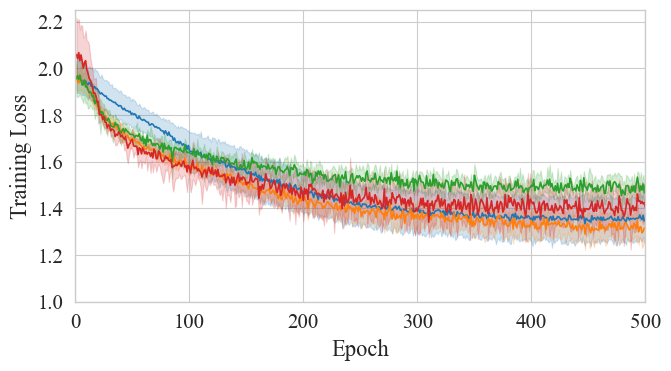

In [7]:
plt.figure(figsize=(7,4))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.7)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"
sns.lineplot(x="epoch", y="train_loss", data=big_df, hue="Model", hue_order=["Llama-3.1 (8B)", "Llama-3.1 (70B)", "gpt-oss (20B)", "gpt-oss (120B)"])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.xlim(0,500)
plt.legend("",[],frameon=False)
plt.tight_layout()
plt.ylim(1.0, 2.25)
plt.savefig("training_loss_models.pdf", bbox_inches="tight")
# plt.legend(frameon=False,bbox_to_anchor=(1.05, 0.75), loc='upper left')

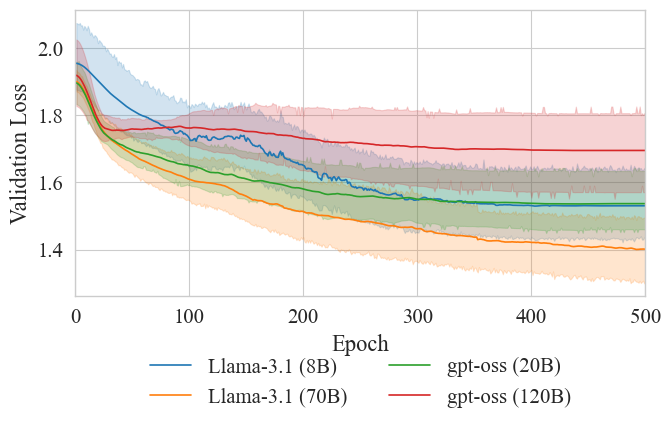

In [8]:
plt.figure(figsize=(7,4.8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.7)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"
sns.lineplot(x="epoch", y="val_loss", data=big_df, hue="Model", hue_order=["Llama-3.1 (8B)", "Llama-3.1 (70B)", "gpt-oss (20B)", "gpt-oss (120B)"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.xlim(0,500)
plt.legend(frameon=False,bbox_to_anchor=(0.5, -0.3), loc='center', ncol=2)
plt.tight_layout()
# plt.ylim(1.0, 2.25)
plt.savefig("val_loss_models.pdf", bbox_inches="tight")